In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path
from lifetimes.plotting import \
    plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases, \
    plot_transaction_rate_heterogeneity, \
    plot_dropout_rate_heterogeneity


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.0f}'.format

In [146]:
df_pop = pd.read_csv('pop_cltv.csv')
df_pop = df_pop.drop(['opa_id_1'], axis=1)
df_pop['transaction_date'] = pd.to_datetime(df_pop.transaction_date, utc=True).dt.tz_convert('Asia/Jakarta')
df_pop

,opa_id,transaction_id,product_category,transaction_date,quantity,monetary_value,user_type,source_aggregate,meta_loaded_at
0,67762797663b71565b1411ff00b8483712dcdd3a5a2170606,1490288410331897856,P2P TRANSFER,2022-02-07 01:36:59+07:00,1,"55,000",DEBIT,VIRGO,2023-01-09 14:07:50.867385 UTC
1,67762da8552da2fad78da1bb76af30a429eb6dc942fe47518,1471121700410646528,UNIPIN,2021-12-16 04:15:20+07:00,1,"20,000",DEBIT,VIRGO,2023-01-09 14:07:50.867385 UTC
2,67762c0796f4d1bcb1347f2dc39629a7da1db6d8423576612,1469621475212668928,P2P TRANSFER,2021-12-12 00:53:58+07:00,1,"51,000",DEBIT,VIRGO,2023-01-09 14:07:50.867385 UTC
3,67762b3ce41d0f5167a8bf7b5131872905811791e42dc8128,1551192093545865216,P2P TRANSFER,2022-07-25 03:06:29+07:00,1,"1,129,000",DEBIT,VIRGO,2023-01-09 14:07:50.867385 UTC
4,677622dccc29819c438e45cdec7820d716be8b48590045514,1520637954657390592,P2P TRANSFER,2022-05-01 19:35:15+07:00,1,"108,400",DEBIT,VIRGO,2023-01-09 14:07:50.867385 UTC
...,...,...,...,...,...,...,...,...,...
925860,677629dfa86657e964869ad6800dcf136954b1dcec1d58658,IDP195505154556,DIGITAL,2022-03-01 18:44:40+07:00,1,"15,000",RECIPIENT,IDEXP,2023-01-09 14:07:50.867385 UTC
925861,6776214e9d0c11414a05ee5c0e49b5e7d02e0ecfff36f7139,1477575668030636032,BILL PAYMENT,2022-01-02 23:41:05+07:00,1,"15,000",DEBIT,VIRGO,2023-01-09 14:07:50.867385 UTC
925862,67762bd70293d5e46108ca0a6d899c585f38283439dd63086,1478200941218639872,BILL PAYMENT,2022-01-04 17:05:42+07:00,1,"15,000",DEBIT,VIRGO,2023-01-09 14:07:50.867385 UTC
925863,67762edd543e80eea757c7367603e1ed23d33d446770e4153,1493947189422379008,BILL PAYMENT,2022-02-17 03:55:40+07:00,1,"15,000",DEBIT,VIRGO,2023-01-09 14:07:50.867385 UTC


# 2. BG/NBD Model

## 2.1 Train/Test Split

In [147]:
# train/test split (calibration/holdout)
t_holdout = 240                                         # days to reserve for holdout period

max_date = df_pop["transaction_date"].max()                     # end date of observations
print("end of observations:", max_date)

max_cal_date = max_date - timedelta(days=t_holdout)     # end date of chosen calibration period
print("end of calibration period:", max_cal_date)

df_ch = calibration_and_holdout_data(
        transactions = df_pop, 
        customer_id_col = "opa_id", 
        datetime_col = "transaction_date",
        monetary_value_col = "monetary_value", 
        calibration_period_end = max_cal_date, 
        observation_period_end = max_date, 
        freq = "D")  

print("customer behavior in calibration and holdout periods")
pd.options.display.float_format = '{:,.0f}'.format
df_ch

end of observations: 2023-01-08 23:49:25+07:00
end of calibration period: 2022-05-13 23:49:25+07:00
customer behavior in calibration and holdout periods


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
opa_id,,,,,,,
677620000214f821919a675a050ab4ed8940431e983a34771,2,119,422,"36,500",0,0,240
6776200003ddc4d1f128718d5bd4dc6aff0c9a20fc03e9041,1,355,377,"46,199",0,0,240
6776200006cb28698ae16eec8ee7683d7c387277732823522,1,139,253,"63,000",0,0,240
677620000ee98e928b632e73b53efc62f95476eec49cb0490,1,11,96,"113,870",3,"141,090",240
6776200018ccb3ded761a88c8136032b3450239c65d008416,0,0,169,0,0,0,240
...,...,...,...,...,...,...,...
67762fffe8a06b8a8eb539f16969214064490286289805600,0,0,290,0,0,0,240
67762fffebf77427d51befad107ef4510c06a36d5047f0104,0,0,225,0,1,"49,038",240
67762fffed30b605f1f03f34935afd3b611adc97248827771,0,0,72,0,0,0,240


In [148]:
df_ch.describe()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,"166,197","166,197","166,197","166,197","166,197","166,197","166,197"
mean,3,112,308,"70,368",1,"37,145",240
std,6,145,145,"1,255,380",2,"294,143",0
min,0,0,0,0,0,0,240
25%,0,0,196,0,0,0,240
50%,1,19,346,"33,000",0,0,240
75%,3,213,435,"88,777",1,"9,501",240
max,212,490,490,"418,083,267",222,"50,006,500",240


In [149]:
# training: frequency
pd.options.display.float_format = '{:,.3f}'.format
x = df_ch["frequency_cal"].value_counts(normalize=True)
x = x.nlargest(15)
print("frequency:")
x.sort_index(ascending=True)

frequency:


0.000    0.405
1.000    0.176
2.000    0.111
3.000    0.069
4.000    0.049
5.000    0.036
6.000    0.027
7.000    0.022
8.000    0.017
9.000    0.014
10.000   0.011
11.000   0.010
12.000   0.008
13.000   0.006
14.000   0.005
Name: frequency_cal, dtype: float64

In [150]:
# training: axis length
max_freq = df_ch["frequency_cal"].quantile(0.98)
max_rec = df_ch["recency_cal"].max()
max_T = df_ch["T_cal"].max()

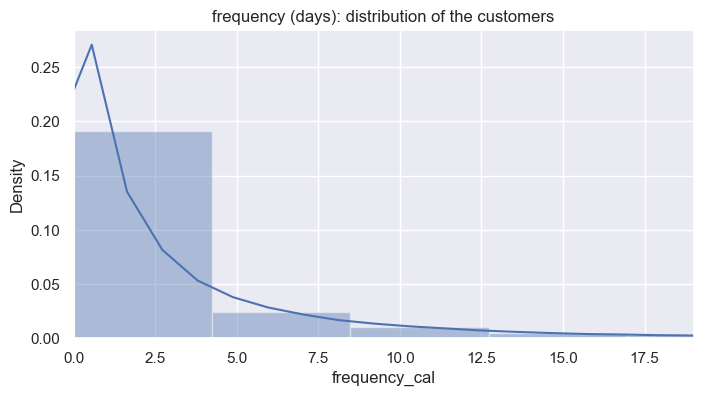

In [151]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["frequency_cal"])
ax.set_xlim(0, max_freq)
ax.set_title("frequency (days): distribution of the customers");

Text(0.5, 1.0, 'recency (days): distribution of the customers')

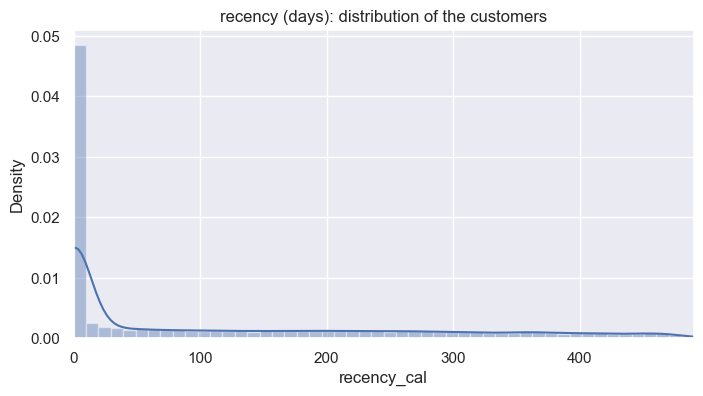

In [152]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["recency_cal"])
ax.set_xlim(0, max_rec)
ax.set_title("recency (days): distribution of the customers")

Text(0.5, 1.0, 'customer age T (days): distribution of the customers')

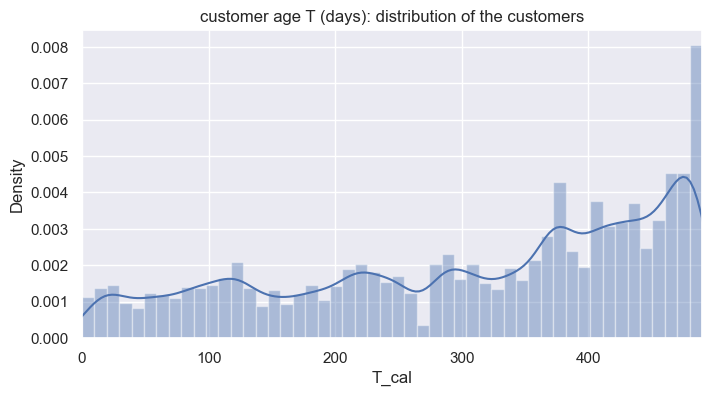

In [153]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["T_cal"])
ax.set_xlim(0, max_T)
ax.set_title("customer age T (days): distribution of the customers")

## 2.2 Fit the BG/NBD Model

In [216]:
# training: BG/NBD model
bgf = BetaGeoFitter()
bgf.fit(
        frequency = df_ch["frequency_cal"], 
        recency = df_ch["recency_cal"], 
        T = df_ch["T_cal"],   
        weights = None,  
        verbose = True)

Optimization terminated successfully.
         Current function value: -3.308672
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26


<lifetimes.BetaGeoFitter: fitted with 166197 subjects, a: 1.24, alpha: 18.16, b: 6.34, r: 0.36>

In [217]:
# training: summary
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.358,0.002,0.354,0.361
alpha,18.157,0.157,17.850,18.465
a,1.242,0.023,1.198,1.286
b,6.340,0.152,6.043,6.638


<Figure size 1200x1200 with 0 Axes>

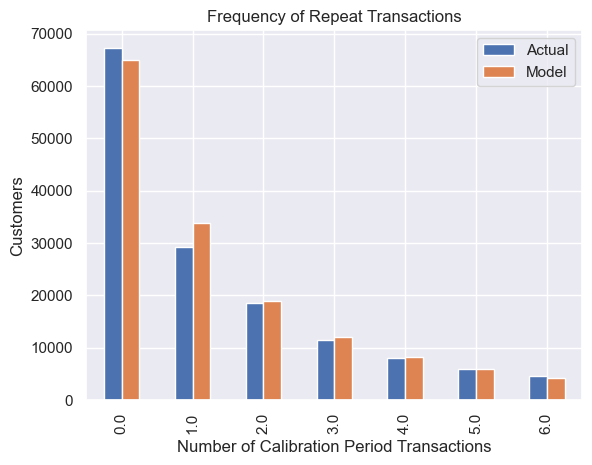

In [218]:
# training: does the model reflect the actual data closely enough?

# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf);

<Figure size 700x700 with 0 Axes>

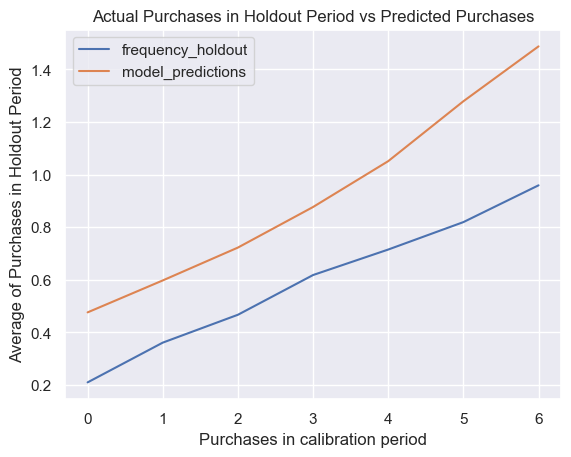

In [219]:
# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7)) 
plot_calibration_purchases_vs_holdout_purchases(bgf, df_ch);

# 3. Fitting Model to Full Dataset

## 3.1 Customer Recency, Frequency, Age T, Monetary Value (Revenues) for Each Customer

In [220]:
# determine recency, frequency, T, monetary value for each customer
df_rft = summary_data_from_transaction_data(
    transactions = df_pop, 
    customer_id_col = "opa_id", 
    datetime_col = "transaction_date", 
    monetary_value_col = "monetary_value", 
    observation_period_end = max_date, 
    freq = "D")

pd.options.display.float_format = '{:,.0f}'.format
df_rft

,frequency,recency,T,monetary_value
opa_id,,,,
677620000214f821919a675a050ab4ed8940431e983a34771,2,119,662,"36,500"
6776200003ddc4d1f128718d5bd4dc6aff0c9a20fc03e9041,1,355,617,"46,199"
6776200006cb28698ae16eec8ee7683d7c387277732823522,1,139,493,"63,000"
677620000ee98e928b632e73b53efc62f95476eec49cb0490,4,296,336,"134,285"
6776200018ccb3ded761a88c8136032b3450239c65d008416,0,0,409,0
...,...,...,...,...
67762fffe8a06b8a8eb539f16969214064490286289805600,0,0,530,0
67762fffebf77427d51befad107ef4510c06a36d5047f0104,1,269,465,"98,076"
67762fffed30b605f1f03f34935afd3b611adc97248827771,0,0,312,0


In [221]:
df_rft.describe()

,frequency,recency,T,monetary_value
count,"169,547","169,547","169,547","169,547"
mean,3,174,541,"81,574"
std,7,210,152,"1,259,098"
min,0,0,1,0
25%,0,0,423,0
50%,1,65,581,"42,667"
75%,4,326,674,"96,130"
max,290,730,730,"418,083,267"


## 3.2 Fitting the BG/NBD Model

In [222]:
# BG/NBD model
bgf = BetaGeoFitter(1e-07)
bgf.fit(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"],   
        weights = None,  
        verbose = True,   
        tol = 1e-07)
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

Optimization terminated successfully.
         Current function value: -4.499620
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.314,0.001,0.311,0.316
alpha,17.357,0.144,17.075,17.639
a,1.769,0.029,1.712,1.826
b,8.495,0.181,8.141,8.849


In [223]:
#axis length
max_freq = int(df_rft["frequency"].max())  #quantile(0.95))          
max_T = int(df_rft["T"].max())                         
max_rec = int(df_rft["recency"].max())  
print(max_freq)

290


<Figure size 1200x1200 with 0 Axes>

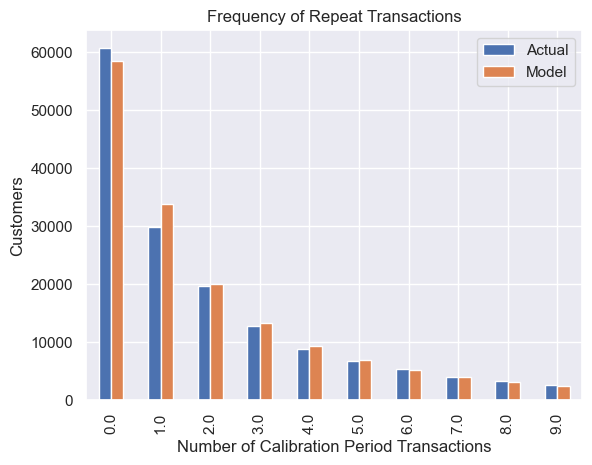

In [224]:
# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(
            model = bgf,  
            max_frequency = 10);

## 3.3 Predictions

In [225]:
# helper function: plot expected number of future purchases a customer with 
#    frequency f and recency r will make in forecast period

def plot_freq_rec(t):
    fig = plt.figure(figsize=(7, 7)) 
    plot_frequency_recency_matrix(
            model = bgf,   
            T = t,  
            max_frequency = max_freq,  
            max_recency = max_rec);

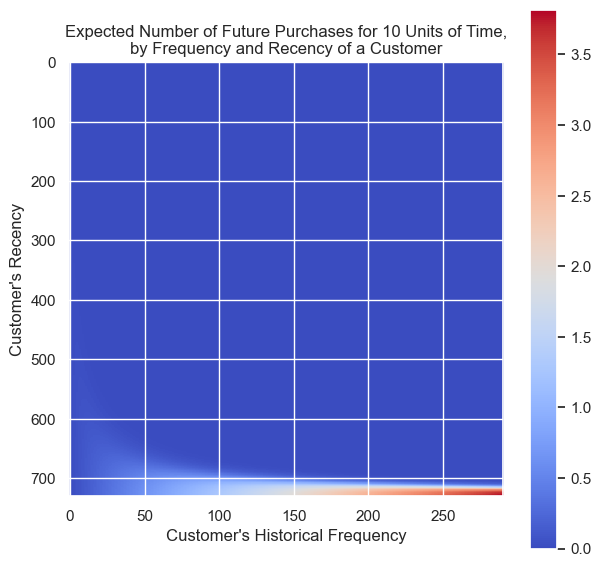

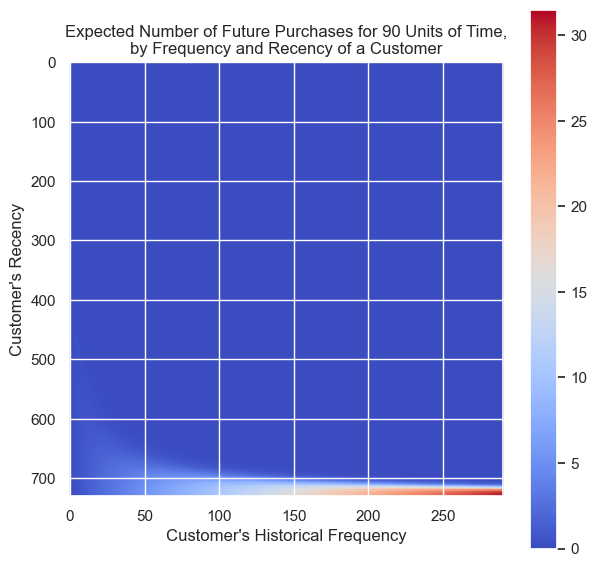

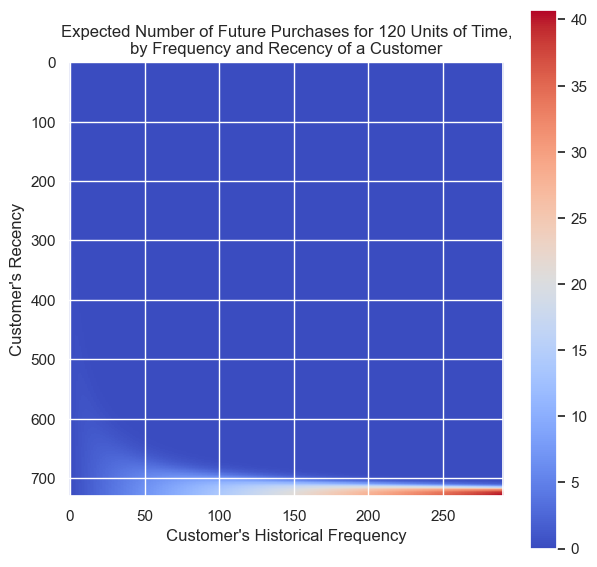

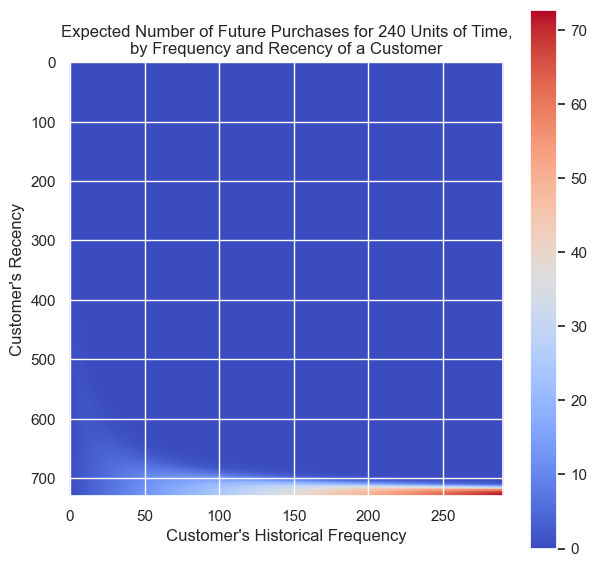

In [226]:
# call plotter function for different forecast periods:
tFC = [10, 90, 120, 240]
_ = [plot_freq_rec(t) for t in tFC]

In [227]:
# predict purchases for a selected customer for t days
t = 120
custID = '677620000ee98e928b632e73b53efc62f95476eec49cb0490'

df_rft_C = df_rft.loc[custID,:]
predC = bgf.predict(    t, 
                        df_rft_C["frequency"], 
                        df_rft_C["recency"], 
                        df_rft_C["T"])
print("customer", custID, ": expected number of purchases within", t, "days =", f'{predC:.1f}')

customer 677620000ee98e928b632e73b53efc62f95476eec49cb0490 : expected number of purchases within 120 days = 1.0


In [228]:
# selected customer: transactions
df_popC = df_pop[df_pop["opa_id"] == custID]
df_popC.describe()

,quantity,monetary_value
count,7.000,7.000
mean,4.714,"126,102.857"
std,6.343,"51,519.096"
min,1.000,"85,058.000"
25%,1.000,"105,183.000"
50%,1.000,"111,860.000"
75%,7.500,"117,865.000"
max,14.000,"239,706.000"


730


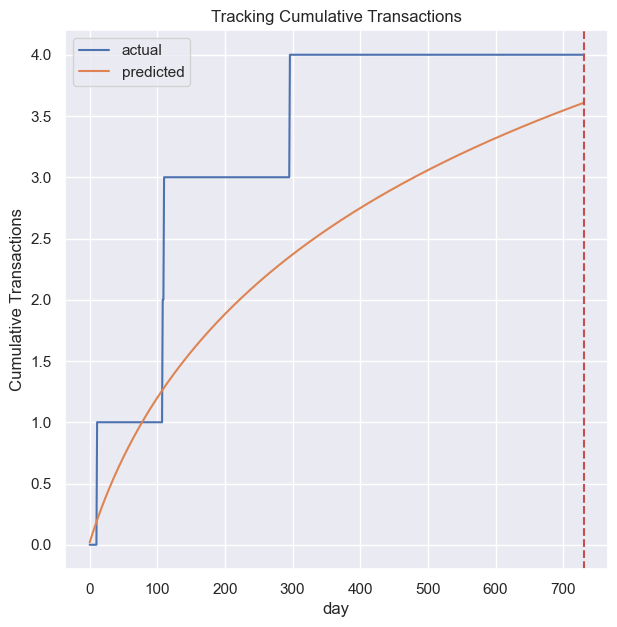

In [229]:
# X selected customer: cumulative transactions
max_date = df_pop["transaction_date"].max()
min_date = df_pop["transaction_date"].min()
span_days = (max_date - min_date).days
print(span_days)

fig = plt.figure(figsize=(7, 7)) 
plot_cumulative_transactions(
            model = bgf,  
            transactions = df_popC, 
            datetime_col = "transaction_date",  
            customer_id_col = "opa_id",  
            t = span_days,  
            t_cal = span_days);

In [230]:
# helper function: predict each customer's purchases over next t days
def predict_purch(df, t):
        df["predict_purch_" + str(t)] = \
                bgf.predict(
                    t, 
                    df["frequency"], 
                    df["recency"], 
                    df["T"])

In [231]:
# call helper function: predict each customer's purchases over multiple time periods
t_FC = [10, 30, 60, 90, 120, 240]
_ = [predict_purch(df_rft, t) for t in t_FC]
pd.options.display.float_format = '{:,.1f}'.format
print("predicted number of purchases for each customer over next t days:")
df_rft

predicted number of purchases for each customer over next t days:


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,predict_purch_120,predict_purch_240
opa_id,,,,,,,,,,
677620000214f821919a675a050ab4ed8940431e983a34771,2.0,119.0,662.0,"36,500.0",0.0,0.0,0.0,0.0,0.0,0.1
6776200003ddc4d1f128718d5bd4dc6aff0c9a20fc03e9041,1.0,355.0,617.0,"46,199.0",0.0,0.0,0.1,0.1,0.2,0.3
6776200006cb28698ae16eec8ee7683d7c387277732823522,1.0,139.0,493.0,"63,000.0",0.0,0.0,0.1,0.1,0.1,0.3
677620000ee98e928b632e73b53efc62f95476eec49cb0490,4.0,296.0,336.0,"134,285.0",0.1,0.3,0.6,0.8,1.0,1.9
6776200018ccb3ded761a88c8136032b3450239c65d008416,0.0,0.0,409.0,0.0,0.0,0.0,0.0,0.1,0.1,0.2
...,...,...,...,...,...,...,...,...,...,...
67762fffe8a06b8a8eb539f16969214064490286289805600,0.0,0.0,530.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1
67762fffebf77427d51befad107ef4510c06a36d5047f0104,1.0,269.0,465.0,"98,076.0",0.0,0.1,0.1,0.2,0.2,0.4
67762fffed30b605f1f03f34935afd3b611adc97248827771,0.0,0.0,312.0,0.0,0.0,0.0,0.1,0.1,0.1,0.2


In [232]:
# top 10 customers over next 30 days
print("top 10 customers, by their predicted purchases over next 30 days")
df_rft.sort_values(by="predict_purch_30", ascending=False).head(10)

top 10 customers, by their predicted purchases over next 30 days


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,predict_purch_120,predict_purch_240
opa_id,,,,,,,,,,
6776286b7e0ed7aa6cb400a612c606eb6d341075f25b77071,290.0,400.0,400.0,"405,177.6",6.8,19.5,37.0,52.6,66.7,111.8
677626e7dd4a3599511759441ef0434aa70d1858504f21212,138.0,331.0,331.0,"2,230,463.0",3.8,11.0,20.6,29.1,36.7,60.3
67762fcfd11478fbc05905174370980caac971922c10e5212,279.0,729.0,730.0,"288,982.1",3.7,10.7,20.8,30.2,39.1,69.9
677621dc2cec5af31eef545c95e38c0a2e14700d3c8820837,227.0,723.0,724.0,"1,490,943.7",3.0,8.8,17.0,24.8,32.0,57.2
677622a4aeb021bb23da29276cf57d193608909a2285e0937,127.0,385.0,388.0,"272,330.0",3.0,8.6,16.2,23.1,29.3,49.2
6776261f47d1486bc40faada7762bf0f98bc2ec6421bd3193,118.0,394.0,394.0,"357,085.5",2.8,8.0,15.2,21.7,27.5,46.2
677628f9765cd8f96a95067e4047b68e32a219e6a3f8b9178,204.0,729.0,729.0,"140,799.6",2.7,7.9,15.3,22.2,28.7,51.3
677628c43c120998faf6bed40a7092250c87711f10a331188,223.0,720.0,730.0,"464,810.6",2.6,7.5,14.5,21.1,27.3,48.9
677624fe86b79bfd834e2de58f75ab0ac7fa4fb2577870550,115.0,444.0,445.0,"8,061.7",2.4,7.0,13.3,19.0,24.3,41.4


# recency, frequency, T
dfx = df_pop[df_pop["CustomerID"] == '6776286b7e0ed7aa6cb400a612c606eb6d341075f25b77071']
xmax_date = dfx["transaction_date"].max()
xmin_date = dfx["transaction_date"].min()

# recency:
print("customer minimum date:", xmin_date)
print("customer maximum date:", xmax_date)
xrec = (xmax_date - xmin_date).days
print("recency:", xrec)                                    # recency = time span between first and last purchase

# age T:
xmaxall_date = df_pop["transaction_date"].max()
print("population maximum date:", xmaxall_date)
xage = (xmaxall_date - xmin_date).days                    # age T
print("T:", xage)

# frequency:
xfreq = len(dfx[dfx["Quantity"] > 0].groupby("InvoiceDate"))-1    # frequency: periods with repeat purchases
print("frequency:", xfreq)

predicted average number of customer purchases over next 90 days:


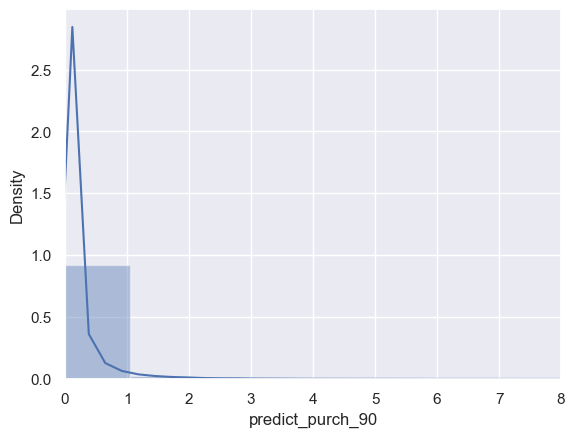

In [233]:
print("predicted average number of customer purchases over next 90 days:")
ax = sns.distplot(df_rft["predict_purch_90"]).set_xlim(0,8)

In [234]:
# helper function: probability of n repeat purchases within t days
def prob_purch(t, n):
    p = bgf.probability_of_n_purchases_up_to_time(t, n)
    return p

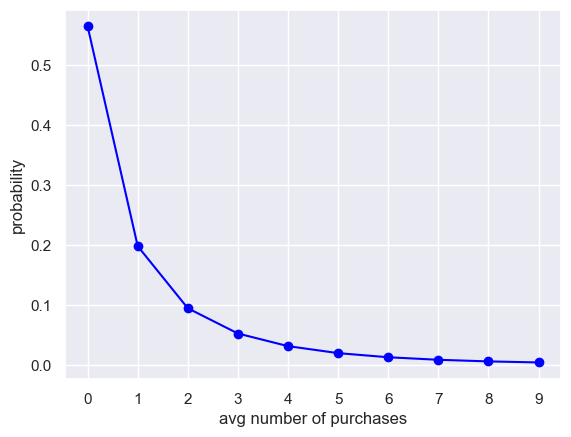

In [235]:
# call helper function: probability of n repeat purchases within t days
t = 90                  # forecast period, days
purch = range(0,10,1)   # number of repeat purchases 
probs = [prob_purch(t,n) for n in purch]

dict_probs = dict(zip(purch, probs))
#_ = [print(k,":",f'{v:.2f}') for k,v in dict_probs.items()]

plt.plot(purch, probs, '-o', color='blue')
plt.xlabel("avg number of purchases")
plt.ylabel("probability")
plt.xticks(purch)
plt.show()

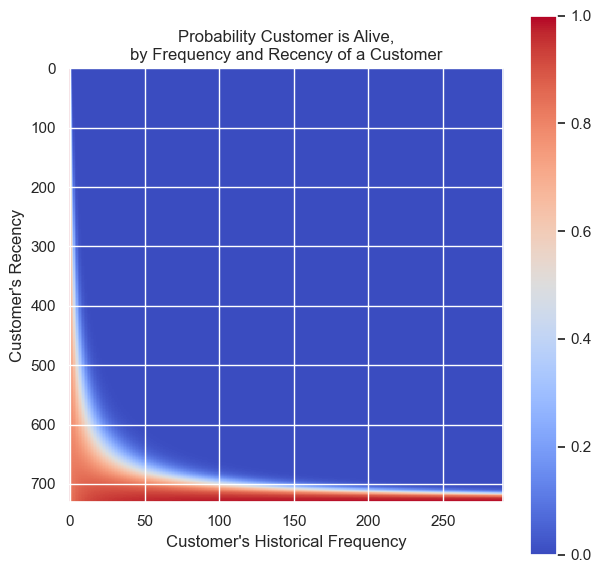

In [236]:
# probability that a customer has not churned (= is alive), based on 
# customer's specific recency r and frequency f
fig = plt.figure(figsize=(7, 7)) 
plot_probability_alive_matrix(
            model = bgf,  
            max_frequency = max_freq,  
            max_recency = max_rec);

In [237]:
# probability that a customer is alive for each customer in dataframe
prob_alive = bgf.conditional_probability_alive(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"])

df_rft["prob_alive"] = prob_alive
pd.options.display.float_format = '{:,.2f}'.format
df_rft.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,predict_purch_120,predict_purch_240,prob_alive
count,"169,547.00","169,547.00","169,547.00","169,547.00","169,547.00","169,547.00","169,547.00","169,547.00","169,547.00","169,547.00","169,547.00"
mean,3.42,174.21,540.80,"81,573.95",0.02,0.07,0.14,0.20,0.26,0.49,0.58
std,6.90,210.29,152.48,"1,259,097.84",0.07,0.20,0.38,0.55,0.71,1.25,0.40
min,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,423.00,0.00,0.00,0.01,0.03,0.04,0.05,0.10,0.14
50%,1.00,65.00,581.00,"42,666.67",0.01,0.02,0.04,0.07,0.09,0.17,0.67
75%,4.00,326.00,674.00,"96,130.29",0.02,0.06,0.12,0.17,0.23,0.43,1.00
max,290.00,730.00,730.00,"418,083,266.67",6.78,19.54,36.95,52.58,66.68,111.75,1.00


In [238]:
# show customers who are alive, but with less than 90% certainty
df_rft[df_rft["prob_alive"] < 0.9]

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,predict_purch_120,predict_purch_240,prob_alive
opa_id,,,,,,,,,,,
677620000214f821919a675a050ab4ed8940431e983a34771,2.00,119.00,662.00,"36,500.00",0.00,0.01,0.02,0.03,0.05,0.09,0.12
6776200003ddc4d1f128718d5bd4dc6aff0c9a20fc03e9041,1.00,355.00,617.00,"46,199.00",0.01,0.04,0.09,0.13,0.17,0.33,0.70
6776200006cb28698ae16eec8ee7683d7c387277732823522,1.00,139.00,493.00,"63,000.00",0.01,0.04,0.08,0.11,0.15,0.29,0.50
677620000ee98e928b632e73b53efc62f95476eec49cb0490,4.00,296.00,336.00,"134,285.00",0.10,0.28,0.55,0.81,1.05,1.91,0.79
6776200032fde8a36c42e92b866edade9586552b67b2b4678,4.00,400.00,432.00,"50,586.25",0.08,0.23,0.46,0.67,0.87,1.62,0.83
...,...,...,...,...,...,...,...,...,...,...,...
67762fffc2d2ba0127d6c8429c9698dcd395161bc182f8558,6.00,637.00,643.00,"68,129.33",0.08,0.25,0.49,0.72,0.94,1.76,0.88
67762fffd15dee47ec80ebcd90812d4b5e7c7012aa6ba1669,8.00,506.00,681.00,"58,336.75",0.05,0.16,0.30,0.45,0.59,1.10,0.44
67762fffde9a4b700ecdc03a495bed55bb68da89e90049414,2.00,258.00,726.00,"315,920.00",0.01,0.03,0.06,0.10,0.13,0.24,0.35


In [239]:
# pick a customer
custID = '677620000214f821919a675a050ab4ed8940431e983a34771'
df_rft[df_rft.index == custID]

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,predict_purch_120,predict_purch_240,prob_alive
opa_id,,,,,,,,,,,
677620000214f821919a675a050ab4ed8940431e983a34771,2.00,119.00,662.00,"36,500.00",0.00,0.01,0.02,0.03,0.05,0.09,0.12


In [240]:
# select a customer

custID = '677620000214f821919a675a050ab4ed8940431e983a34771'

df_popC = df_pop[df_pop["opa_id"] == custID]
df_popC.describe()

,quantity,monetary_value
count,3.00,3.00
mean,1.00,"31,666.33"
std,0.00,"31,146.32"
min,1.00,"6,500.00"
25%,1.00,"14,249.50"
50%,1.00,"21,999.00"
75%,1.00,"44,249.50"
max,1.00,"66,500.00"


customer 677620000214f821919a675a050ab4ed8940431e983a34771 : probability of being alive over time


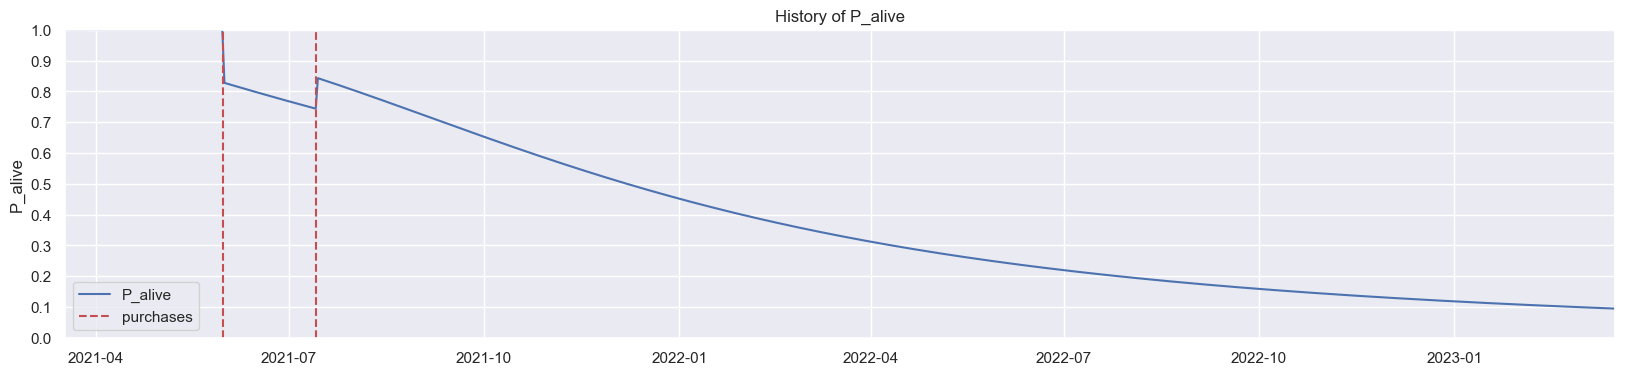

In [241]:
# history of the selected customer: probability over time of being alive
fig = plt.figure(figsize=(20,4))
print("customer",custID,": probability of being alive over time")
plot_history_alive(
                    model = bgf, 
                    t = span_days, 
                    transactions = df_popC, 
                    datetime_col = "transaction_date");

In [242]:
# selected customer's probability of being alive - development over time
path_alive = calculate_alive_path(
            model = bgf, 
            t = span_days, 
            transactions = df_popC, 
            datetime_col = "transaction_date");
print("customer",custID,"'s probability of being alive, development over time")
path_alive.explode().astype(np.float64).describe()

customer 677620000214f821919a675a050ab4ed8940431e983a34771 's probability of being alive, development over time


count   731.00
mean      0.43
std       0.30
min       0.09
25%       0.17
50%       0.33
75%       0.69
max       1.00
dtype: float64

In [243]:
path_alive

0                      [1.0]
1                      [1.0]
2                      [1.0]
3                      [1.0]
4                      [1.0]
               ...          
726    [0.09592270519306968]
727     [0.0956533086106685]
728    [0.09538494911155238]
729    [0.09511762176532013]
730    [0.09485132166856279]
Length: 731, dtype: object

# 4 Customer Lifetime Value: The Gamma-Gamma Model
## 4.1 Fitting the Gamma-Gamma Model

In [244]:
# select customers with monetary value > 0
df_rftv = df_rft[df_rft["monetary_value"] > 0]
pd.options.display.float_format = '{:,.2f}'.format
df_rftv.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,predict_purch_120,predict_purch_240,prob_alive
count,"108,851.00","108,851.00","108,851.00","108,851.00","108,851.00","108,851.00","108,851.00","108,851.00","108,851.00","108,851.00","108,851.00"
mean,5.33,271.35,575.31,"127,060.10",0.03,0.10,0.19,0.28,0.36,0.67,0.35
std,7.99,206.20,139.82,"1,569,568.23",0.08,0.24,0.47,0.67,0.87,1.53,0.31
min,1.00,1.00,5.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,82.00,481.00,"46,499.00",0.00,0.01,0.01,0.02,0.03,0.05,0.05
50%,3.00,246.00,619.00,"78,235.00",0.01,0.04,0.07,0.11,0.14,0.26,0.28
75%,6.00,440.00,692.00,"128,100.87",0.03,0.10,0.20,0.29,0.38,0.72,0.64
max,290.00,730.00,730.00,"418,083,266.67",6.78,19.54,36.95,52.58,66.68,111.75,0.99


In [245]:
# Gamma-Gamma model requires a Pearson correlation close to 0 
# between purchase frequency and monetary value

corr_matrix = df_rftv[["monetary_value", "frequency"]].corr()
corr = corr_matrix.iloc[1,0]
print("Pearson correlation: %.3f" % corr)

Pearson correlation: 0.011


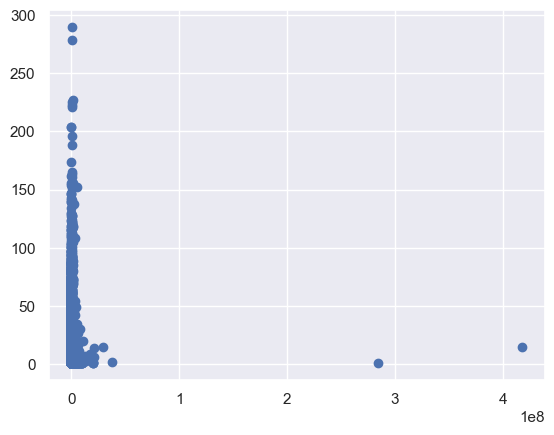

In [246]:
dfx = df_rftv["monetary_value"]
dfy = df_rftv["frequency"]
plt.scatter(dfx, dfy)


In [247]:
# outlier
df_rftv[df_rftv["monetary_value"] == df_rftv["monetary_value"].max()]

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,predict_purch_120,predict_purch_240,prob_alive
opa_id,,,,,,,,,,,
67762cd169f655e48ae608b507234c637f0de42065e546778,15.00,65.00,656.00,"418,083,266.67",0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [277]:
# fitting the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef = 1e-06)
ggf.fit(
        frequency = df_rftv["frequency"],
        monetary_value = df_rftv["monetary_value"],  
        weights = None,   
        verbose = True,  
        tol = 1e-06,
        q_constraint = True)
pd.options.display.float_format = '{:,.3f}'.format
ggf.summary

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33463D+01    |proj g|=  1.10511D+00

At iterate    1    f=  2.00689D+01    |proj g|=  9.99656D-01

At iterate    2    f=  1.31081D+01    |proj g|=  4.58906D-01

At iterate    3    f=  1.29602D+01    |proj g|=  7.99762D-02

At iterate    4    f=  1.29583D+01    |proj g|=  4.50798D-02

At iterate    5    f=  1.29577D+01    |proj g|=  3.06786D-02

At iterate    6    f=  1.29557D+01    |proj g|=  3.63373D-02

At iterate    7    f=  1.29542D+01    |proj g|=  2.78491D-02

At iterate    8    f=  1.29538D+01    |proj g|=  7.06787D-04

At iterate    9    f=  1.29538D+01    |proj g|=  1.62190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

,coef,se(coef),lower 95% bound,upper 95% bound
p,156.511,0.903,154.741,158.280
q,1.000,0.004,0.993,1.007
v,242.424,1.405,239.670,245.178


In [280]:
242.424 * 156.511/(1-1)

ZeroDivisionError: float division by zero

## 4.2 Predictions

In [278]:
print('Is there null value left?\n')
print(df_rftv.isnull().any())
print(df_rftv.dtypes)

Is there null value left?

CLV                  False
frequency            False
recency              False
T                    False
monetary_value       False
predict_purch_10     False
predict_purch_30     False
predict_purch_60     False
predict_purch_90     False
predict_purch_120    False
predict_purch_240    False
prob_alive           False
exp_avg_rev          False
avg_rev              False
error_rev            False
dtype: bool
CLV                  float64
frequency            float64
recency              float64
T                    float64
monetary_value       float64
predict_purch_10     float64
predict_purch_30     float64
predict_purch_60     float64
predict_purch_90     float64
predict_purch_120    float64
predict_purch_240    float64
prob_alive           float64
exp_avg_rev          float64
avg_rev              float64
error_rev            float64
dtype: object


In [279]:
ggf.conditional_expected_average_profit(frequency = 1, monetary_value = 50000)

nan

In [276]:
ggf._unload_params("q")

[2.998271166542333]

In [273]:
# estimate the average transaction value of each customer, based on frequency and monetary value
exp_avg_rev = ggf.conditional_expected_average_profit(
        df_rftv["frequency"],
        df_rftv["monetary_value"])

df_rftv["exp_avg_rev"] = exp_avg_rev
df_rftv["avg_rev"] = df_rftv["monetary_value"]
df_rftv["error_rev"] = df_rftv["exp_avg_rev"] - df_rftv["avg_rev"]

# mape = mean_absolute_percentage_error(exp_avg_rev, df_rftv["monetary_value"])
# print("MAPE of predicted revenues:", f'{mape:.2f}')

pd.options.display.float_format = '{:,.3f}'.format
df_rftv.head()

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,predict_purch_120,predict_purch_240,prob_alive,exp_avg_rev,avg_rev,error_rev
opa_id,,,,,,,,,,,,,,,
677620000214f821919a675a050ab4ed8940431e983a34771,"8,545.330",2.000,119.000,662.000,"36,500.000",0.004,0.012,0.023,0.034,0.045,0.087,0.116,"69,790.855","36,500.000","33,290.855"
6776200003ddc4d1f128718d5bd4dc6aff0c9a20fc03e9041,"40,277.215",1.000,355.000,617.000,"46,199.000",0.015,0.043,0.086,0.128,0.169,0.328,0.705,"86,901.482","46,199.000","40,702.482"
6776200006cb28698ae16eec8ee7683d7c387277732823522,"37,753.345",1.000,139.000,493.000,"63,000.000",0.013,0.038,0.076,0.113,0.149,0.287,0.504,"93,588.539","63,000.000","30,588.539"
677620000ee98e928b632e73b53efc62f95476eec49cb0490,"330,192.813",4.000,296.000,336.000,"134,285.000",0.096,0.283,0.551,0.806,1.049,1.913,0.795,"128,668.013","134,285.000","-5,616.987"
6776200032fde8a36c42e92b866edade9586552b67b2b4678,"149,943.353",4.000,400.000,432.000,"50,586.250",0.079,0.233,0.455,0.669,0.875,1.623,0.825,"67,933.844","50,586.250","17,347.594"


In [253]:
exp_avg_rev.describe()

count       108,851.000
mean        123,472.897
std       1,222,238.138
min           4,320.840
25%          74,053.481
50%          91,948.714
75%         122,765.021
max     379,781,794.540
dtype: float64

In [254]:
# compute customer lifetime value
DISCOUNT_a = 0.06                # annual discount rate
LIFE = 12                        # lifetime expected for the customers in months

discount_m = (1 + DISCOUNT_a)**(1/12) - 1     # monthly discount rate

clv = ggf.customer_lifetime_value(
        transaction_prediction_model = bgf,  
        frequency = df_rftv["frequency"],  
        recency = df_rftv["recency"],  
        T = df_rftv["T"],  
        monetary_value = df_rftv["monetary_value"],  
        time = LIFE,    
        freq = "D",                          
        discount_rate = discount_m)

df_rftv.insert(0, "CLV", clv)             # expected customer lifetime values
df_rftv.describe().T

,count,mean,std,min,25%,50%,75%,max
CLV,"108,851.000","136,807.307","1,389,471.211",0.000,"7,005.379","36,699.558","100,633.087","165,437,778.393"
frequency,"108,851.000",5.331,7.993,1.000,1.000,3.000,6.000,290.000
recency,"108,851.000",271.349,206.203,1.000,82.000,246.000,440.000,730.000
T,"108,851.000",575.310,139.824,5.000,481.000,619.000,692.000,730.000
monetary_value,"108,851.000","127,060.102","1,569,568.234",10.000,"46,499.000","78,235.000","128,100.865","418,083,266.667"
predict_purch_10,"108,851.000",0.033,0.083,0.000,0.002,0.012,0.034,6.776
predict_purch_30,"108,851.000",0.097,0.243,0.000,0.007,0.036,0.100,19.542
predict_purch_60,"108,851.000",0.189,0.466,0.000,0.014,0.071,0.196,36.954
predict_purch_90,"108,851.000",0.278,0.674,0.000,0.021,0.105,0.290,52.576
predict_purch_120,"108,851.000",0.362,0.867,0.000,0.028,0.138,0.381,66.682


In [255]:
df_rftv.sort_values(by="CLV", ascending=False)

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,predict_purch_120,predict_purch_240,prob_alive,exp_avg_rev,avg_rev,error_rev
opa_id,,,,,,,,,,,,,,,
677626e7dd4a3599511759441ef0434aa70d1858504f21212,"165,437,778.393",138.000,331.000,331.000,"2,230,463.043",3.831,10.984,20.604,29.108,36.685,60.291,0.988,"2,207,505.349","2,230,463.043","-22,957.694"
67762761a394b791ac14d1d26a8141ffc97724c26f4046461,"164,383,996.118",15.000,448.000,485.000,"29,779,864.333",0.240,0.705,1.366,1.986,2.570,4.599,0.798,"27,061,359.421","29,779,864.333","-2,718,504.912"
677623b624f87abf7cb0714893f11dcfd73c94ef438d61854,"130,484,145.061",153.000,615.000,627.000,"2,761,652.719",1.963,5.741,11.070,16.030,20.661,36.487,0.836,"2,735,721.540","2,761,652.719","-25,931.179"
677621dc2cec5af31eef545c95e38c0a2e14700d3c8820837,"111,861,598.493",227.000,723.000,724.000,"1,490,943.714",3.001,8.802,17.040,24.767,32.033,57.236,0.990,"1,481,824.571","1,490,943.714","-9,119.142"
6776201fe14c237d8c8de9b52728f1dfd9ec81841ed353514,"106,480,821.288",27.000,275.000,279.000,"6,693,797.222",0.839,2.410,4.534,6.423,8.113,13.433,0.931,"6,344,593.630","6,693,797.222","-349,203.593"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677629c025c2030398672fefadc5f90ab6b30f8a89a083212,0.000,103.000,142.000,403.000,"11,796.165",0.000,0.000,0.000,0.000,0.000,0.000,0.000,"13,273.823","11,796.165","1,477.658"
677627361f577be32436c80bcaab4b5607b52af14768d2423,0.000,139.000,309.000,675.000,"188,429.324",0.000,0.000,0.000,0.000,0.000,0.000,0.000,"187,626.193","188,429.324",-803.131
677623ccf441518deafd9a9bdd1f61f07931d549c39216841,0.000,72.000,81.000,395.000,"89,765.819",0.000,0.000,0.000,0.000,0.000,0.000,0.000,"90,261.640","89,765.819",495.820


# 5 Parameter Distributions

<AxesSubplot: title={'center': 'mean: 0.018, var: 0.001'}, xlabel='Transaction Rate', ylabel='Density'>

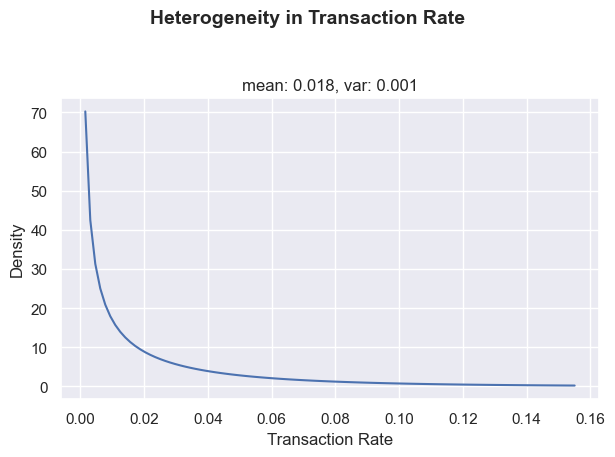

In [256]:
# Gamma distribution of lambda: customers' propensitiy to purchase
plot_transaction_rate_heterogeneity(model = bgf)   

<AxesSubplot: title={'center': 'mean: 0.172, var: 0.013'}, xlabel='Dropout Probability p', ylabel='Density'>

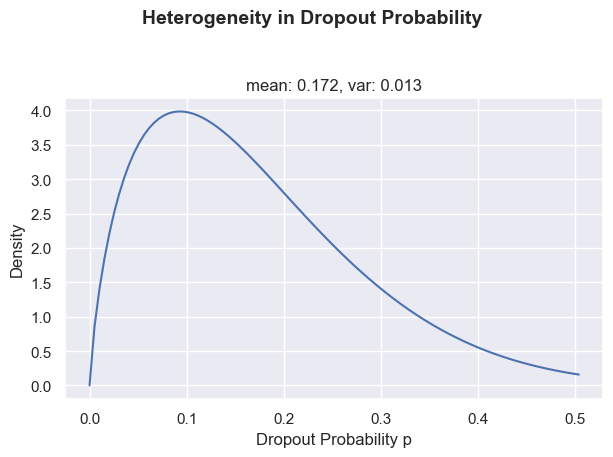

In [257]:
# Beta distribution of p: customer's probability of dropping out immediately after a transaction
plot_dropout_rate_heterogeneity(model = bgf)